# 0-Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import nltk
import re
import tensorflow as tf
from tensorflow.keras import Sequential,Model
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense,MaxPool1D,Dropout,Embedding,Activation,Convolution1D,add,BatchNormalization,Flatten,Reshape,Concatenate,LSTM,GRU
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,Callback
from tensorflow.keras.optimizers import Adam,SGD,Adamax,RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1-Reading the dataset
Data source : https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022
This dataset contains reviews of Spotify App from 1/1/2022 - 7/9/2022 collected from Google Play Store. The dataset contains 5 collums which are as following:
* **Time_submitted**: the timestamp when the review was submitted
* **Review**: Customers review about the application
* **Rating**: Given rating for the application
* **Total_thumsup**: How many people found the review helpful
* **Reply**: Reply to customer review 


In [2]:
df = pd.read_csv('reviews.csv')

In [3]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [4]:
df.shape

(61594, 5)

# 2-Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


2-1- Dropping unused columns


For our project, we will use only 2 columns from the dataset, which are the "Review" and "Rating". While "Review" will be used as feature, "Rating" will be our target label with 5 different class of (1,2,3,4,5)

In [6]:
spotify = df.drop(['Time_submitted', 'Total_thumbsup','Reply'], axis =1)
spotify

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1
...,...,...
61589,Even though it was communicated that lyrics fe...,1
61590,"Use to be sooo good back when I had it, and wh...",1
61591,This app would be good if not for it taking ov...,2
61592,The app is good hard to navigate and won't jus...,2


 2-2- Finding the class number

In [7]:
spotify['Rating'].nunique()

5

 2-3- Finding and eliminating the duplicate rows

In [8]:
spotify.duplicated().sum()

201

In [9]:
spotify = spotify.drop_duplicates(keep="first")

In [10]:
spotify.shape

(61393, 2)

2-4 Checking null values

<AxesSubplot:>

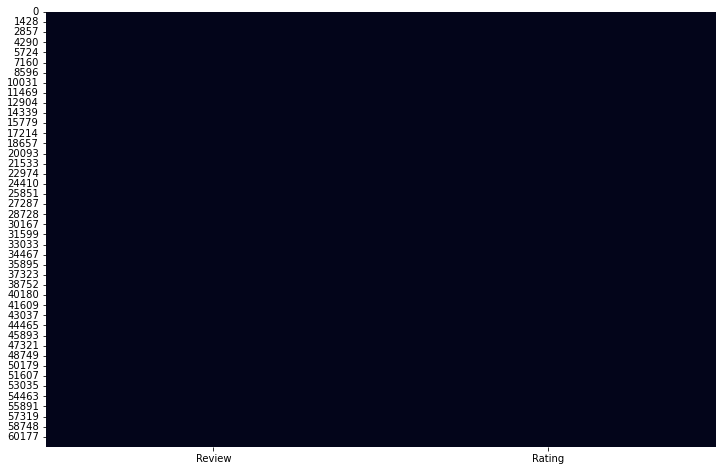

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(spotify.isnull(),cbar=False)

In [12]:
spotify.isnull().values.any() 

False

 2-5- Distribution of classes

In [13]:
spotify.Rating.value_counts()

5    21950
1    17617
4     7831
2     7114
3     6881
Name: Rating, dtype: int64

<AxesSubplot:xlabel='Rating', ylabel='count'>

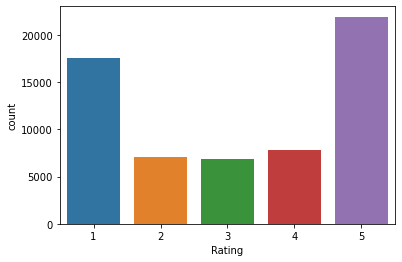

In [14]:
sns.countplot(x='Rating', data=spotify)

In [15]:
spotify['Review'][0]

'Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.'

# 3-Data Preprocessing

 3-1 Text(Review) cleaning

In this part, we cleaned the text of each review by defining a function with the help of Re library (lower case, removing punctuation, removing URLs, removing next line character, transforming some informal words to the formal ones, removng stopwords and lemmitization)

In [16]:
stop_words = stopwords.words('english')
lemmetizer = WordNetLemmatizer()

def textpreprocess(s):
    """This function cleans the text
    Input: string to be cleaned
    Return: string after cleaning
    """
    words = [] # empty list
    
    s = s.strip().lower() # lower the string
    s = re.sub(r"won't", "will not", s)
    s = re.sub(r"can\'t", "can not", s)    
    s = re.sub(r"n\'t", " not", s)
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'d", " would", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    s = re.sub('\[.*?\]', '', s) # removes symbols (.*?\)
    s = re.sub('https?://\S+|www\.\S+', '', s) # remove URLS
    s = re.sub('<.*?>+', '', s)
    s = re.sub('[%s]' % re.escape(string.punctuation), '', s) # remove punctuations
    s = re.sub('\n', '', s) # remove next line character
    s = re.sub('\w*\d\w*', '', s)
   
    words = s.split() # split the string into list of words
    words = [lemmetizer.lemmatize(word) for word in words if word not in stop_words] # removing stop words
    s = ' '.join(words) # converting list to string
    return s

Applying the defined function on the reviews and adding a Cleaned_Review column

In [17]:
Cleaned_Review = []
sentences = list(spotify['Review'])
for i in sentences:
    Cleaned_Review.append(textpreprocess(i))

In [18]:
spotify['Cleaned_Review'] = Cleaned_Review
spotify

C:\Users\PC\AppData\Local\Temp\ipykernel_9236\30757753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify['Cleaned_Review'] = Cleaned_Review


,Review,Rating,Cleaned_Review
0,"Great music service, the audio is high quality...",5,great music service audio high quality app eas...
1,Please ignore previous negative rating. This a...,5,please ignore previous negative rating app sup...
2,"This pop-up ""Get the best Spotify experience o...",4,popup get best spotify experience android anno...
3,Really buggy and terrible to use as of recently,1,really buggy terrible use recently
4,Dear Spotify why do I get songs that I didn't ...,1,dear spotify get song put playlist shuffle play
...,...,...,...
61589,Even though it was communicated that lyrics fe...,1,even though communicated lyric feature availab...
61590,"Use to be sooo good back when I had it, and wh...",1,use sooo good back downloaded free version cou...
61591,This app would be good if not for it taking ov...,2,app would good taking device start comp spotif...
61592,The app is good hard to navigate and won't jus...,2,app good hard navigate let play song click pla...


3-2- Calculating the length of each review 

In [19]:
spotify['Length'] = spotify.Cleaned_Review.apply(lambda x:len(x))
spotify


C:\Users\PC\AppData\Local\Temp\ipykernel_9236\1305701456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify['Length'] = spotify.Cleaned_Review.apply(lambda x:len(x))


,Review,Rating,Cleaned_Review,Length
0,"Great music service, the audio is high quality...",5,great music service audio high quality app eas...,79
1,Please ignore previous negative rating. This a...,5,please ignore previous negative rating app sup...,69
2,"This pop-up ""Get the best Spotify experience o...",4,popup get best spotify experience android anno...,69
3,Really buggy and terrible to use as of recently,1,really buggy terrible use recently,34
4,Dear Spotify why do I get songs that I didn't ...,1,dear spotify get song put playlist shuffle play,47
...,...,...,...,...
61589,Even though it was communicated that lyrics fe...,1,even though communicated lyric feature availab...,170
61590,"Use to be sooo good back when I had it, and wh...",1,use sooo good back downloaded free version cou...,156
61591,This app would be good if not for it taking ov...,2,app would good taking device start comp spotif...,284
61592,The app is good hard to navigate and won't jus...,2,app good hard navigate let play song click pla...,135


In [20]:
spotify.Length.max()

2207

In [21]:
spotify.Length.min()

2

In [22]:
spotify.Length.mean()

99.9702083299399

In [23]:
spotify.Length.mode()

0    44
Name: Length, dtype: int64

In [24]:
spotify['Review'][0]

'Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.'

In [25]:
spotify['Cleaned_Review'][0]

'great music service audio high quality app easy use also quick friendly support'

 3-3- Defining the features and labels

In [30]:
X = list(spotify['Cleaned_Review'])
y = spotify['Rating']

 3-4- Splitting the dataset for train and test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [27]:
len(X_train)

49114

 3-5-Tokenization of reviews

In [28]:
num_words_ = 5000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=num_words_, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [29]:
tokenizer.word_index

 3-6- Applying pad sequence on X_train and X_test for equality of the review's length

In [30]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 300
trunc_type='post'
padding_type='post'

X_train = pad_sequences(X_train, maxlen=maxlen, truncating= trunc_type, padding=padding_type)
X_test = pad_sequences(X_test, padding=padding_type, maxlen=maxlen, truncating= trunc_type)

In [31]:
X_train[0]

array([ 98, 456, 269, 399,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [32]:
y_train[0]

5

 3-7- Changing the range of labels from [1,5) to [0,4]

In [33]:
y_test = y_test.map(lambda x: x % 5)

In [34]:
y_train = y_train.map(lambda x: x % 5)

3-8-Loading pretrained 50 dimension Glove embedding

In [35]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/kaggle/input/glove6b50dtxt/glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [36]:
embeddings_dictionary

 3-9- Creating embedding matrix

In [37]:
embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [38]:
embedding_matrix.shape

(25539, 50)

# 4- Data Modeling and Optimization

 * Firstly, we define a base model for our dataset(model_1) using fully connected (dense) layer. Here, for the model metric, we are using the accuracy score since this is a multi-classification problem 
 * Next, we manually tweak our model by changing the number of layers and number of nodes in each layer to improve the model accuracy.
 * In the next step, we replace one of the dense layer with LSTM/GRU model to benchmark the model performance
 * Following that, we pick the best model architecture and perform manually hyperparameter tunning by examining different type of optimizers on the model.
 * Finally we apply keras random search tuner as another hyperparameter tunner for benchmarking

 4-1- Base model

In [128]:
model_1 = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model_1.add(embedding_layer)
model_1.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_1.add(Flatten())
model_1.add(Dense(5, activation='softmax'))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_1.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [129]:
history = model_1.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 15)

Epoch 1/15
1228/1228 [==============================] - 4s 3ms/step - loss: 1.4458 - accuracy: 0.4280 - val_loss: 1.3779 - val_accuracy: 0.4662
Epoch 2/15
1228/1228 [==============================] - 4s 3ms/step - loss: 1.3710 - accuracy: 0.4683 - val_loss: 1.3403 - val_accuracy: 0.4880
Epoch 3/15
1228/1228 [==============================] - 3s 3ms/step - loss: 1.3350 - accuracy: 0.4885 - val_loss: 1.3098 - val_accuracy: 0.5039
Epoch 4/15
1228/1228 [==============================] - 4s 3ms/step - loss: 1.3028 - accuracy: 0.5037 - val_loss: 1.2833 - val_accuracy: 0.5200
Epoch 5/15
1228/1228 [==============================] - 4s 3ms/step - loss: 1.2760 - accuracy: 0.5155 - val_loss: 1.2621 - val_accuracy: 0.5264
Epoch 6/15
1228/1228 [==============================] - 4s 3ms/step - loss: 1.2545 - accuracy: 0.5240 - val_loss: 1.2456 - val_accuracy: 0.5327
Epoch 7/15
1228/1228 [==============================] - 4s 3ms/step - loss: 1.2374 - accuracy: 0.5306 - val_loss: 1.2329 - val_accuracy:

In [126]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model 1 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

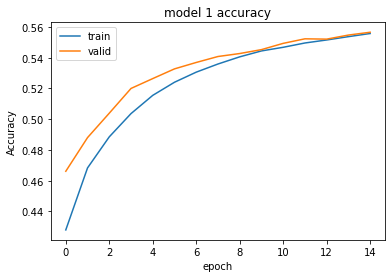

In [130]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

Here, the val_accuracy is higher than the train_accuracy, suggesting that the model is underfitting. Also,both learning curves converge toward the last epoch and on the increasing trend, suggesting that there is still a room to increase the accuracy score when increasing the number of epochs.

In [131]:
 test_loss, test_acc = model_1.evaluate(X_test, y_test)

384/384 [==============================] - 1s 2ms/step - loss: 1.1736 - accuracy: 0.5617


In [132]:
#4-3- adding another dense layer with 8 nodes
# model_2 = Sequential()
# embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

# model_2.add(embedding_layer)
# model_2.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
# model_2.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
# model_2.add(Flatten())
# model_2.add(Dense(5, activation='softmax'))

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
# model_2.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [133]:
# history = model_2.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 20)

In [135]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model 2 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

In [137]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])

# plt.title('model 2 accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

In [53]:
# test_loss, test_acc = model_2.evaluate(X_test, y_test)

384/384 [==============================] - 1s 2ms/step - loss: 1.1600 - accuracy: 0.5657


In [54]:
#4-4- Adding another dense layer with 32 units
# model_3 = Sequential()
# embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

# model_3.add(embedding_layer)
# model_3.add(Dense(32, activation='relu', kernel_initializer="he_normal" ))
# model_3.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
# model_3.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
# model_3.add(Flatten())
# model_3.add(Dense(5, activation='softmax'))

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
# model_3.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [138]:
# history = model_3.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 20)

In [140]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model 3 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

In [142]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])

# plt.title('model 3 accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

In [58]:
# test_loss, test_acc = model_3.evaluate(X_test, y_test)

384/384 [==============================] - 1s 3ms/step - loss: 1.1516 - accuracy: 0.5691


In [143]:
# 4-5- Adding another dense layer with 8 units
# model_4 = Sequential()
# embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

# model_4.add(embedding_layer)
# model_4.add(Dense(32, activation='relu', kernel_initializer="he_normal" ))
# model_4.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
# model_4.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
# model_4.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
# model_4.add(Flatten())
# model_4.add(Dense(5, activation='softmax'))

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
# model_4.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [149]:
# history = model_4.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 20)

In [147]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model 4 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

In [145]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])

# plt.title('model 4 accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

In [148]:
# test_loss, test_acc = model_4.evaluate(X_test, y_test)

4-2 Adding more hidden layer

We start to increase the model complexity by adding dense layer to our model step-by-step to observe the change in the accuracy model. Below is the 2nd model we have after a few trial. We also increase the number of epochs as suggested above.

*For easy following, all the step taken in model 2,3,4 are commented out as only a little improvement is made.*

In [150]:
model_5 = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model_5.add(embedding_layer)
model_5.add(Dense(32, activation='relu', kernel_initializer="he_normal" ))
model_5.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_5.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_5.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
model_5.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
model_5.add(Flatten())
model_5.add(Dense(5, activation='softmax'))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_5.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [151]:
history = model_5.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 40)

Epoch 1/40
1228/1228 [==============================] - 9s 6ms/step - loss: 1.4448 - accuracy: 0.4219 - val_loss: 1.3971 - val_accuracy: 0.4483
Epoch 2/40
1228/1228 [==============================] - 7s 6ms/step - loss: 1.4044 - accuracy: 0.4424 - val_loss: 1.3772 - val_accuracy: 0.4610
Epoch 3/40
1228/1228 [==============================] - 7s 6ms/step - loss: 1.3817 - accuracy: 0.4554 - val_loss: 1.3528 - val_accuracy: 0.4755
Epoch 4/40
1228/1228 [==============================] - 8s 6ms/step - loss: 1.3541 - accuracy: 0.4747 - val_loss: 1.3260 - val_accuracy: 0.4942
Epoch 5/40
1228/1228 [==============================] - 7s 5ms/step - loss: 1.3279 - accuracy: 0.4936 - val_loss: 1.3046 - val_accuracy: 0.5046
Epoch 6/40
1228/1228 [==============================] - 7s 6ms/step - loss: 1.3059 - accuracy: 0.5031 - val_loss: 1.2894 - val_accuracy: 0.5133
Epoch 7/40
1228/1228 [==============================] - 7s 5ms/step - loss: 1.2853 - accuracy: 0.5119 - val_loss: 1.2673 - val_accuracy:

In [152]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model 5 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

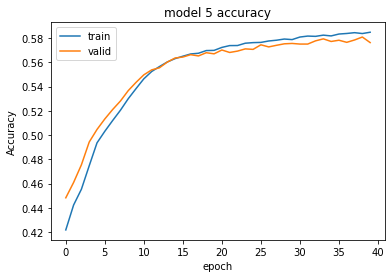

In [153]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model 5 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

Train_accuracy is better than val_accurary after 10 epochs. Both learning curve continue increase toward last epoch,the test accuracy score is also slightly better in this second model

In [154]:
test_loss, test_acc = model_5.evaluate(X_test, y_test)

384/384 [==============================] - 2s 6ms/step - loss: 1.1102 - accuracy: 0.5781


In [156]:
#4-7- Adding some nodes randomly to the layers
# model_6 = Sequential()
# embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

# model_6.add(embedding_layer)
# model_6.add(Dense(64, activation='relu', kernel_initializer="he_normal" ))
# model_6.add(Dense(32, activation='relu', kernel_initializer="he_normal" ))
# model_6.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
# model_6.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
# model_6.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
# model_6.add(Flatten())
# model_6.add(Dense(5, activation='softmax'))

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
# model_6.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [155]:
# history = model_6.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 40)

In [157]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model 6 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

In [158]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])

# plt.title('model 6 accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

In [159]:
# test_loss, test_acc = model_6.evaluate(X_test, y_test)

4-3 Adding more nodes

We continue our process by adding some nodes to the hidden layer

*For easy following, model 6 is also commented out*

In [160]:
model_7 = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model_7.add(embedding_layer)
model_7.add(Dense(128, activation='relu', kernel_initializer="he_normal" ))
model_7.add(Dense(64, activation='relu', kernel_initializer="he_normal" ))
model_7.add(Dense(32, activation='relu', kernel_initializer="he_normal" ))
model_7.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_7.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
model_7.add(Flatten())
model_7.add(Dense(5, activation='softmax'))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_7.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [161]:
history = model_7.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 40)

Epoch 1/40
1228/1228 [==============================] - 9s 7ms/step - loss: 1.4228 - accuracy: 0.4454 - val_loss: 1.3335 - val_accuracy: 0.4894
Epoch 2/40
1228/1228 [==============================] - 8s 6ms/step - loss: 1.2956 - accuracy: 0.5092 - val_loss: 1.2448 - val_accuracy: 0.5360
Epoch 3/40
1228/1228 [==============================] - 8s 6ms/step - loss: 1.2246 - accuracy: 0.5404 - val_loss: 1.1997 - val_accuracy: 0.5515
Epoch 4/40
1228/1228 [==============================] - 8s 7ms/step - loss: 1.1890 - accuracy: 0.5516 - val_loss: 1.1736 - val_accuracy: 0.5581
Epoch 5/40
1228/1228 [==============================] - 8s 7ms/step - loss: 1.1670 - accuracy: 0.5581 - val_loss: 1.1584 - val_accuracy: 0.5642
Epoch 6/40
1228/1228 [==============================] - 8s 6ms/step - loss: 1.1528 - accuracy: 0.5636 - val_loss: 1.1542 - val_accuracy: 0.5689
Epoch 7/40
1228/1228 [==============================] - 8s 6ms/step - loss: 1.1415 - accuracy: 0.5679 - val_loss: 1.1384 - val_accuracy:

In [162]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model 7 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

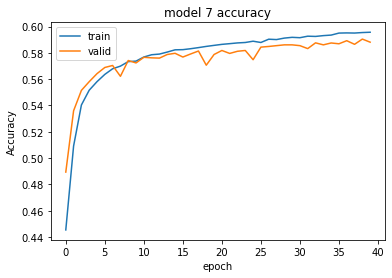

In [163]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model 7 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

Toward the last epochs, val_accuracy curve started to fluctuate while train_accuracy continued to go up, showing the early sign of overfitting. The test accuracy score is higher but yet to our desired level (<60%), we are now going to use LSTM/GRU model to observe the difference.

In [164]:
test_loss, test_acc = model_7.evaluate(X_test, y_test)

384/384 [==============================] - 2s 6ms/step - loss: 1.0731 - accuracy: 0.5912


4-3 LSTM/GRU model


In [166]:
model_Ls = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model_Ls.add(embedding_layer)
model_Ls.add(LSTM(32, activation='relu', kernel_initializer="he_normal" ))

model_Ls.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_Ls.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_Ls.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
model_Ls.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))

model_Ls.add(Flatten())
model_Ls.add(Dense(5, activation='softmax'))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_Ls.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [168]:
history = model_Ls.fit(X_train, y_train, validation_split=0.2, batch_size = 256, epochs = 10)

Epoch 1/10
154/154 [==============================] - 80s 518ms/step - loss: 1.5902 - accuracy: 0.3578 - val_loss: 1.5858 - val_accuracy: 0.3639
Epoch 2/10
154/154 [==============================] - 79s 516ms/step - loss: 1.5832 - accuracy: 0.3578 - val_loss: 1.5788 - val_accuracy: 0.3639
Epoch 3/10
154/154 [==============================] - 80s 517ms/step - loss: 1.5767 - accuracy: 0.3578 - val_loss: 1.5723 - val_accuracy: 0.3639
Epoch 4/10
154/154 [==============================] - 79s 514ms/step - loss: 1.5706 - accuracy: 0.3578 - val_loss: 1.5663 - val_accuracy: 0.3639
Epoch 5/10
154/154 [==============================] - 79s 515ms/step - loss: 1.5649 - accuracy: 0.3578 - val_loss: 1.5606 - val_accuracy: 0.3639
Epoch 6/10
154/154 [==============================] - 79s 516ms/step - loss: 1.5597 - accuracy: 0.3578 - val_loss: 1.5553 - val_accuracy: 0.3639
Epoch 7/10
154/154 [==============================] - 80s 516ms/step - loss: 1.5547 - accuracy: 0.3578 - val_loss: 1.5503 - val_ac

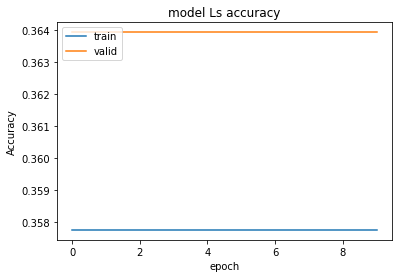

In [169]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model Ls accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model_Ls.evaluate(X_test, y_test)

In [170]:
model_Gr = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model_Gr.add(embedding_layer)
model_Gr.add(GRU(16, activation='relu', kernel_initializer="he_normal" ))

model_Gr.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_Gr.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_Gr.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
model_Gr.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))

model_Gr.add(Flatten())
model_Gr.add(Dense(5, activation='softmax'))


optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_Gr.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [171]:
history = model_Gr.fit(X_train, y_train, validation_split=0.2, batch_size = 256, epochs = 10)

Epoch 1/10
154/154 [==============================] - 109s 702ms/step - loss: 1.6052 - accuracy: 0.3578 - val_loss: 1.6007 - val_accuracy: 0.3639
Epoch 2/10
154/154 [==============================] - 99s 643ms/step - loss: 1.5970 - accuracy: 0.3578 - val_loss: 1.5925 - val_accuracy: 0.3639
Epoch 3/10
154/154 [==============================] - 102s 664ms/step - loss: 1.5893 - accuracy: 0.3578 - val_loss: 1.5848 - val_accuracy: 0.3639
Epoch 4/10
154/154 [==============================] - 109s 711ms/step - loss: 1.5821 - accuracy: 0.3578 - val_loss: 1.5777 - val_accuracy: 0.3639
Epoch 5/10
154/154 [==============================] - 99s 646ms/step - loss: 1.5754 - accuracy: 0.3578 - val_loss: 1.5710 - val_accuracy: 0.3639
Epoch 6/10
154/154 [==============================] - 98s 636ms/step - loss: 1.5692 - accuracy: 0.3578 - val_loss: 1.5648 - val_accuracy: 0.3639
Epoch 7/10
154/154 [==============================] - 99s 644ms/step - loss: 1.5634 - accuracy: 0.3578 - val_loss: 1.5589 - val

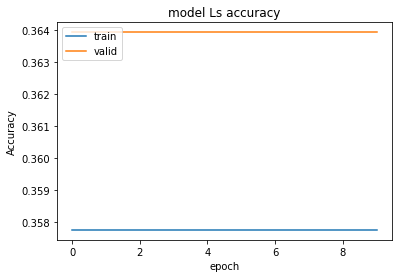

In [172]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model Ls accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [173]:
test_loss, test_acc = model_Gr.evaluate(X_test, y_test)

384/384 [==============================] - 18s 46ms/step - loss: 1.5461 - accuracy: 0.3517


Here, we can see that both LSTM and GRU model do not perform better than our model 7. It could be explained that LSTM and GRU are more suitable for sequential data given its capability to model long-term dependencies in sequential data. For our dataset, the review is given by each customer individually and are more indepedent from each other.

4-9- Continue fine tuning with model 7 and applying different optimizers

In [174]:
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False),
        tf.keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
        tf.keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal"),
        tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
        tf.keras.layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
        tf.keras.layers.Dense(8, activation='relu', kernel_initializer="he_normal"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_split=0.2, 
                     verbose=0) 

SGD

In [82]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

history_sgd = build_and_train_model(optimizer)

SGD with Momentum

In [83]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

history_momentum = build_and_train_model(optimizer)

Nesterov

In [84]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

history_nesterov = build_and_train_model(optimizer)

Ada grad

In [85]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

history_adagrad = build_and_train_model(optimizer)

RMSProp

In [86]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

history_rmsprop = build_and_train_model(optimizer)

Adam

In [87]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

history_adam = build_and_train_model(optimizer)

Adamax

In [88]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

history_adamax = build_and_train_model(optimizer)

Nadam

In [89]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

history_nadam = build_and_train_model(optimizer)

Visualize the learning curves of all the optimizers 

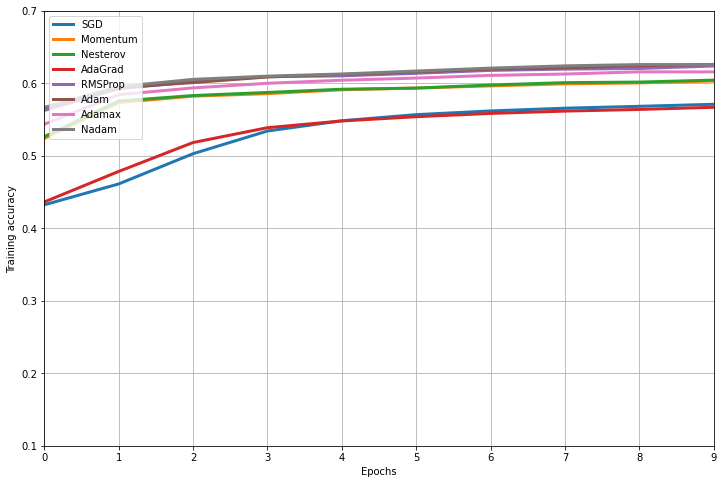

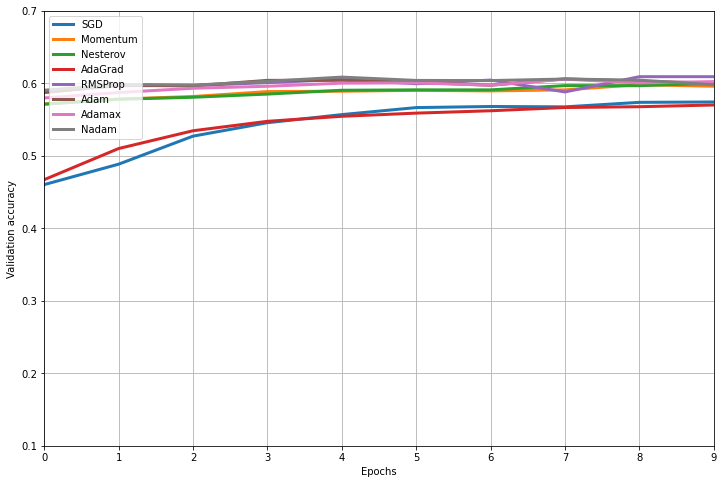

In [90]:
for loss in ("accuracy", "val_accuracy"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam,),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"accuracy": "Training accuracy", "val_accuracy": "Validation accuracy"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

 4-10- Choosing Nadam,RMSPprop and Adam based on the above graph, train the model with these selected optimizers for more epochs

In [91]:
model_7_1 = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model_7_1.add(embedding_layer)
model_7_1.add(Dense(128, activation='relu', kernel_initializer="he_normal" ))
model_7_1.add(Dense(64, activation='relu', kernel_initializer="he_normal" ))
model_7_1.add(Dense(32, activation='relu', kernel_initializer="he_normal" ))
model_7_1.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_7_1.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
model_7_1.add(Flatten())
model_7_1.add(Dense(5, activation='softmax'))

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model_7_1.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [176]:
history = model_7_1.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 40)

Epoch 1/40
1228/1228 [==============================] - 8s 7ms/step - loss: 0.9751 - accuracy: 0.6259 - val_loss: 1.0409 - val_accuracy: 0.6044
Epoch 2/40
1228/1228 [==============================] - 9s 7ms/step - loss: 0.9702 - accuracy: 0.6271 - val_loss: 1.0508 - val_accuracy: 0.6033
Epoch 3/40
1228/1228 [==============================] - 9s 7ms/step - loss: 0.9670 - accuracy: 0.6289 - val_loss: 1.0498 - val_accuracy: 0.6037
Epoch 4/40
1228/1228 [==============================] - 9s 7ms/step - loss: 0.9630 - accuracy: 0.6297 - val_loss: 1.0521 - val_accuracy: 0.5956
Epoch 5/40
1228/1228 [==============================] - 10s 8ms/step - loss: 0.9586 - accuracy: 0.6311 - val_loss: 1.0455 - val_accuracy: 0.6019
Epoch 6/40
1228/1228 [==============================] - 9s 7ms/step - loss: 0.9575 - accuracy: 0.6310 - val_loss: 1.0724 - val_accuracy: 0.6043
Epoch 7/40
1228/1228 [==============================] - 10s 8ms/step - loss: 0.9542 - accuracy: 0.6339 - val_loss: 1.0568 - val_accurac

In [175]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model 7 Nadam loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

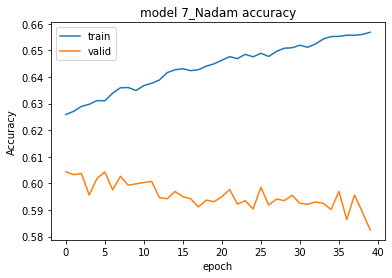

In [177]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model 7_Nadam accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [95]:
test_loss, test_acc = model_7_1.evaluate(X_test, y_test)

384/384 [==============================] - 2s 4ms/step - loss: 1.0293 - accuracy: 0.6039


In [96]:
model_7_2 = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model_7_2.add(embedding_layer)
model_7_2.add(Dense(128, activation='relu', kernel_initializer="he_normal" ))
model_7_2.add(Dense(64, activation='relu', kernel_initializer="he_normal" ))
model_7_2.add(Dense(32, activation='relu', kernel_initializer="he_normal" ))
model_7_2.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_7_2.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
model_7_2.add(Flatten())
model_7_2.add(Dense(5, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_7_2.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [178]:
history = model_7_2.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 40)

Epoch 1/40
1228/1228 [==============================] - 8s 6ms/step - loss: 0.9737 - accuracy: 0.6260 - val_loss: 1.0542 - val_accuracy: 0.6000
Epoch 2/40
1228/1228 [==============================] - 8s 6ms/step - loss: 0.9678 - accuracy: 0.6284 - val_loss: 1.0537 - val_accuracy: 0.6009
Epoch 3/40
1228/1228 [==============================] - 8s 7ms/step - loss: 0.9642 - accuracy: 0.6300 - val_loss: 1.0474 - val_accuracy: 0.6029
Epoch 4/40
1228/1228 [==============================] - 8s 6ms/step - loss: 0.9602 - accuracy: 0.6302 - val_loss: 1.0519 - val_accuracy: 0.6024
Epoch 5/40
1228/1228 [==============================] - 8s 6ms/step - loss: 0.9556 - accuracy: 0.6315 - val_loss: 1.0525 - val_accuracy: 0.6021
Epoch 6/40
1228/1228 [==============================] - 8s 6ms/step - loss: 0.9539 - accuracy: 0.6344 - val_loss: 1.0797 - val_accuracy: 0.6055
Epoch 7/40
1228/1228 [==============================] - 8s 7ms/step - loss: 0.9487 - accuracy: 0.6362 - val_loss: 1.0609 - val_accuracy:

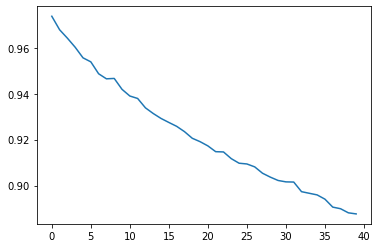

In [179]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model 7_2 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

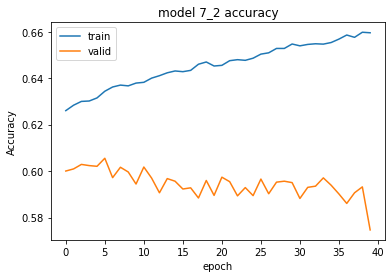

In [180]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model 7_2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [181]:
test_loss, test_acc = model_7_2.evaluate(X_test, y_test)

384/384 [==============================] - 2s 4ms/step - loss: 1.1308 - accuracy: 0.5768


In [101]:
model_7_3 = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model_7_3.add(embedding_layer)
model_7_3.add(Dense(128, activation='relu', kernel_initializer="he_normal" ))
model_7_3.add(Dense(64, activation='relu', kernel_initializer="he_normal" ))
model_7_3.add(Dense(32, activation='relu', kernel_initializer="he_normal" ))
model_7_3.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_7_3.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
model_7_3.add(Flatten())
model_7_3.add(Dense(5, activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model_7_3.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [182]:
history = model_7_3.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 40)

Epoch 1/40
1228/1228 [==============================] - 8s 6ms/step - loss: 0.9905 - accuracy: 0.6208 - val_loss: 1.0446 - val_accuracy: 0.6063
Epoch 2/40
1228/1228 [==============================] - 8s 6ms/step - loss: 0.9862 - accuracy: 0.6231 - val_loss: 1.0458 - val_accuracy: 0.6072
Epoch 3/40
1228/1228 [==============================] - 8s 7ms/step - loss: 0.9839 - accuracy: 0.6237 - val_loss: 1.0450 - val_accuracy: 0.6049
Epoch 4/40
1228/1228 [==============================] - 8s 6ms/step - loss: 0.9810 - accuracy: 0.6224 - val_loss: 1.0442 - val_accuracy: 0.6050
Epoch 5/40
1228/1228 [==============================] - 8s 6ms/step - loss: 0.9804 - accuracy: 0.6231 - val_loss: 1.0416 - val_accuracy: 0.6065
Epoch 6/40
1228/1228 [==============================] - 8s 6ms/step - loss: 0.9776 - accuracy: 0.6263 - val_loss: 1.0867 - val_accuracy: 0.6095
Epoch 7/40
1228/1228 [==============================] - 8s 7ms/step - loss: 0.9749 - accuracy: 0.6260 - val_loss: 1.0486 - val_accuracy:

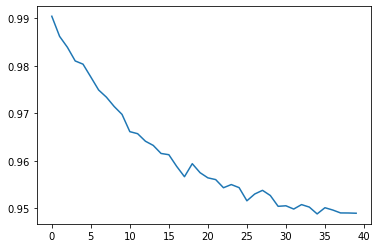

In [183]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model 7_3 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','valid'], loc='upper left')
# plt.show()

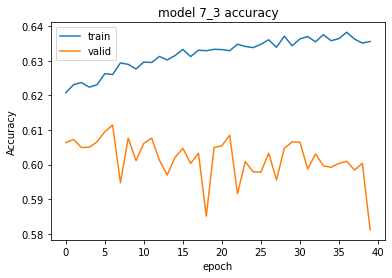

In [187]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model 7_3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [184]:
test_loss, test_acc = model_7_3.evaluate(X_test, y_test)

384/384 [==============================] - 2s 5ms/step - loss: 1.0875 - accuracy: 0.5832


A significant increase in model 7 train_accuracy (65%, 65%, 63%) compare to the previous result (59%) as the model converged more quickly with these 3 selected optimizer. Howere, the same impact is not reflected in val_accuracy and test accuracy. All 3 learning curve graph "model 7_1","model 7_2", "model 7_3" shown a clear sign of overfitting as the val_accuracy decrease toward the last epoch and widen the gap between train and validation. 

# 4-12 Keras Random Search Tuner

In this section, after defining train,test and valid dataset, we import keras_tuner and write a function that builds, compiles and returns a keras model.The function must take a kt.HyperParameters object as an argument,in which hyperparameters are defined with their range of possible values. The hyperparameter values are randomply pick to build and compile the model. The combination of hyperparameter values, that provide the highest accurarcy score for model, is then selected to create the best model.
 For our project, the following hyperparameters are selected for fine tunning:
 * Number of hidden layer
 * Number of nodes in each layer
 * Learning rate
 * Type of optimizers

We will run 'build model' function with 8 trial for our dataset. For each trial, this function pick a random value of the predefined range for each hyperparameter and after running 8 different architecture with different set of hyperparameters, the best model is selected based on val_accuracy score.


In [188]:
X = list(spotify['Cleaned_Review'])
y = spotify['Rating']

In [189]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [191]:
y_test = y_test.map(lambda x: x % 5)
y_train = y_train.map(lambda x: x % 5)
y_valid = y_valid.map(lambda x: x % 5)

In [192]:
num_words_ = 5000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=num_words_, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_valid = tokenizer.texts_to_sequences(X_valid)


In [193]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 300
trunc_type='post'
padding_type='post'

X_valid = pad_sequences(X_valid, maxlen=maxlen, truncating= trunc_type, padding=padding_type)
X_train = pad_sequences(X_train, maxlen=maxlen, truncating= trunc_type, padding=padding_type)
X_test = pad_sequences(X_test, padding=padding_type, maxlen=maxlen, truncating= trunc_type)

In [195]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/kaggle/input/glove6b50dtxt/glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()


embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [196]:
import keras_tuner as kt
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=12, default=4)
    n_neurons = hp.Int("n_neurons", min_value=8, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = hp.Choice("optimizer", values=["nadam", "adam", "RMSprop"])
    if optimizer == "nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        
    model = tf.keras.Sequential()
    model.add(embedding_layer)
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Flatten())    
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [197]:
random_search_tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=8, overwrite=True,
directory="spotify", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


Trial 8 Complete [00h 03m 23s]
val_accuracy: 0.5933014154434204

Best val_accuracy So Far: 0.5954392552375793
Total elapsed time: 00h 17m 47s


In [198]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [201]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial summary
Hyperparameters:
n_hidden: 7
n_neurons: 64
learning_rate: 0.00041268008323824807
optimizer: adam
Score: 0.5954392552375793


In [199]:
best_model.fit(X_train, y_train, epochs=40)

Epoch 1/40
1228/1228 [==============================] - 9s 7ms/step - loss: 0.9735 - accuracy: 0.6280
Epoch 2/40
1228/1228 [==============================] - 9s 7ms/step - loss: 0.9632 - accuracy: 0.6321
Epoch 3/40
1228/1228 [==============================] - 8s 7ms/step - loss: 0.9549 - accuracy: 0.6348
Epoch 4/40
1228/1228 [==============================] - 8s 7ms/step - loss: 0.9470 - accuracy: 0.6393
Epoch 5/40
1228/1228 [==============================] - 8s 7ms/step - loss: 0.9363 - accuracy: 0.6438
Epoch 6/40
1228/1228 [==============================] - 9s 7ms/step - loss: 0.9299 - accuracy: 0.6450
Epoch 7/40
1228/1228 [==============================] - 8s 7ms/step - loss: 0.9207 - accuracy: 0.6512
Epoch 8/40
1228/1228 [==============================] - 8s 7ms/step - loss: 0.9129 - accuracy: 0.6537
Epoch 9/40
1228/1228 [==============================] - 9s 7ms/step - loss: 0.9059 - accuracy: 0.6572
Epoch 10/40
1228/1228 [==============================] - 8s 7ms/step - loss: 0.898

In [200]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)

384/384 [==============================] - 2s 5ms/step - loss: 1.4485 - accuracy: 0.5671


With the use of keras tuner, even higher train accuracy score is achieved, but still does not improve the test accuracy. The model becomes too complex and learns the trainning data too well but cannot predict the new and unseen data. 

# 5- Benchmarking with traditional Machine Learning model

In here, we performed an extra step to compare between our deep learning model with other "traditional" machine learning model to see if our network overtrained the data and the prediction can simply be done by simpler model

For our ML model, we used TF-IDF Vectorizer to process our text and examine the accuracy score with LogisticRegression(), DecisionTreeClassifier(), MultinomialNB(), RandomForestClassifier() alogrithm

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [27]:
X = list(spotify['Cleaned_Review'])
y = spotify['Rating']

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer   
v = TfidfVectorizer()
x_tfidf = v.fit_transform((spotify['Cleaned_Review'].values))

In [29]:
X_train,X_test,y_train,y_test=train_test_split(x_tfidf,y,test_size=0.3)

In [30]:
results = []
algorithms = [LogisticRegression(), DecisionTreeClassifier(), MultinomialNB(), RandomForestClassifier()]


for model in algorithms:
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    score = accuracy_score(y_test, predictions)
    results.append(score)

C:\Users\PC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
model =[]
for i in algorithms:
    model.append(str(i))
Spotify_1 = pd.DataFrame(zip(model, results), columns=['Model','Accuracy'])
Spotify_1

,Model,Accuracy
0,LogisticRegression(),0.608915
1,DecisionTreeClassifier(),0.476762
2,MultinomialNB(),0.585731
3,RandomForestClassifier(),0.581876


Except for Decision Tree Classifier , all other ML model (without hyperparameter fine tunning) achieve a similar accuracy score with our DL model. It suggest that further research is needed to improve our DL for this given task.

# 6- Summary

Overall, the accuracy score (aprx 60%) is not a satisfied level in practice. However, the project has provided a great learning experience for us in term of understanding the course material and practicing our coding skill.

We have build and examine our DL model by increasing level of complexity, changing alogrithm, performing fine-tuning with different optimizers and random search. Through these practice, we were able to achieve higher accuracy score in trainning but perform poorly on new and unseen data. For further improvement, we could apply a serveral regularization techniques such as dropout, early stopping to mitigate overfitting. Another practice would be considered is to revise our data preprocessing by using other dictionary or the whole corpus instead of Glove, OR scraping more customer review for our dataset.